# Analysis of Air Disasters from 1919 to 2023

## Preprocessing phase

Let's import the necessary tools to perform the analysis and the dataset on which to conduct it:

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import geopandas as gpd

In [ ]:
url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/aviation-accidents.csv"

data = pd.read_csv(url)
data.head(10)

,date,type,registration,operator,fatalities,location,country,cat,year
0,date unk.,Antonov An-12B,T-1206,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
1,date unk.,Antonov An-12B,T-1204,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
2,date unk.,Antonov An-12B,T-1201,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
3,date unk.,Antonov An-12BK,NaN,Soviet AF,NaN,Tiksi Airport (IKS),Russia,A1,unknown
4,date unk.,Antonov An-12BP,CCCP-11815,Soviet AF,0,Massawa Airport ...,Eritrea,A1,unknown
5,date unk.,Antonov An-12BP,CCCP-12172,Soviet AF,NaN,NaN,Russia,U1,unknown
6,date unk.,Antonov An-2,CCCP-N574,"GUSMP, Directorate of Polar Aviation",NaN,unknown,Russia,A1,unknown
7,date unk.,Antonov An-2,CCCP-01216,Aeroflot,0,Chita region,Russia,A2,unknown
8,date unk.,Antonov An-24B,RA-47794,Russian AF,0,NaN,Russia,A1,unknown
9,date unk.,Antonov An-26,01 red,Soviet AF,0,Orenburg Air Base,Russia,O1,unknown


In [ ]:
data.shape

(23967, 9)

We have a dataset with 9 attributes:


* date: date of the incident
* type: type of aircraft
* registration: aircraft registration code
* operator: aircraft operator
* fatalities: number of deaths
* location: location of the incident
* country: country of the incident
* cat: category of the incident as described by ASN

and 23967 entries.



From first line of the dataset, we can see there are missing data that we need to take into account in order to achieve an efficient analysis. Let's start with NaN:

In [ ]:
data.isna().sum()

date               0
type               0
registration    1548
operator           4
fatalities      3938
location         948
country            0
cat                0
year               0
dtype: int64

"registration" and "location" are not useful variables for this analysis. We'll drop them and see how NaN count changes:

In [ ]:
data = data.drop(['registration', 'location'], axis=1)

In [ ]:
data.isna().sum()

date             0
type             0
operator         4
fatalities    3938
country          0
cat              0
year             0
dtype: int64

Before removing the remaining NaN could be a good idea to assure that 'fatalities' column contains only numeric value.

First step is to evaluate the entries and then convert them to *numeric* type:

In [ ]:
def eval_fatalities(row):
    try:
        # Using pd.eval() to evaluate expression
        return pd.eval(row)
    except:
        # If there is an error (e.g., invalid value), return NaN.
        return pd.NA

In [ ]:
# applyng the function to 'fatalities'
data['fatalities'] = data['fatalities'].apply(eval_fatalities)

# Convertion to numeric type
data['fatalities'] = pd.to_numeric(data['fatalities'], errors='coerce')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23967 entries, 0 to 23966
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        23967 non-null  object 
 1   type        23967 non-null  object 
 2   operator    23963 non-null  object 
 3   fatalities  20029 non-null  float64
 4   country     23967 non-null  object 
 5   cat         23967 non-null  object 
 6   year        23967 non-null  object 
dtypes: float64(1), object(6)
memory usage: 1.3+ MB


The 'date' column also needs to be formatted correctly, in the datetime type:

In [ ]:
# using a regex to define the starting format
accepted_date = r'\d{2}-[A-Z]{3}-\d{4}'

# filtering the column 'date'
data = data[data["date"].str.match(accepted_date)]

# converting to datetime type
data['date'] = pd.to_datetime(data['date'], format='%d-%b-%Y')

# overwriting 'year' column with value extracted from 'date'
data['year'] = data['date'].dt.year

<ipython-input-43-4c8ed8290726>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'], format='%d-%b-%Y')
<ipython-input-43-4c8ed8290726>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data['date'].dt.year


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23408 entries, 61 to 23966
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        23408 non-null  datetime64[ns]
 1   type        23408 non-null  object        
 2   operator    23404 non-null  object        
 3   fatalities  19803 non-null  float64       
 4   country     23408 non-null  object        
 5   cat         23408 non-null  object        
 6   year        23408 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(4)
memory usage: 1.3+ MB


In [ ]:
data.isna().sum()

date             0
type             0
operator         4
fatalities    3605
country          0
cat              0
year             0
dtype: int64

Now we will drop entries which have a NaN in them:

In [ ]:
data = data.dropna()

In [ ]:
data.shape

(19800, 7)

## Analysis phase

### What have been the deadliest aviation accidents?

In [ ]:
total_deaths = data['fatalities'].sum()

# searching the top 10 deadliest accident
top_10_mortality = data.nlargest(10, 'fatalities')

# calculating the impact of every accident over the total
top_10_mortality['impact'] = (top_10_mortality['fatalities'] / total_deaths) * 100

# calculating the cumulate impact of every accident over the total
top_10_mortality['cumulate_impact'] = (top_10_mortality['fatalities'].cumsum() / total_deaths) * 100

top_10_mortality.head(10)

,date,type,operator,fatalities,country,cat,year,impact,cumulate_impact
19403,2001-09-11,Boeing 767-223ER,American Airlines,1692.0,USA,H1,2001,1.275143,1.275143
19404,2001-09-11,Boeing 767-222,United Airlines,965.0,USA,H1,2001,0.727254,2.002397
15484,1985-08-12,Boeing 747SR-46,JAL,520.0,Japan,A1,1985,0.391888,2.394284
12694,1974-03-03,DC-10-10,THY,346.0,France,A1,1974,0.260756,2.655041
13460,1977-03-27,Boeing 747-121,Pan Am,335.0,Spain,A1,1977,0.252466,2.907507
15454,1985-06-23,Boeing 747-237B,Air-India,329.0,Atlantic Ocean,C1,1985,0.247944,3.155451
18291,1996-11-12,Boeing 747-168B,Saudi Arabian,312.0,India,A1,1996,0.235133,3.390584
14364,1980-08-19,Lockheed L-1011 TriStar 200,Saudi Arabian,301.0,Saudi Arabia,A1,1980,0.226843,3.617427
22145,2014-07-17,Boeing 777-2H6ER,Malaysia Airlines,298.0,Ukraine,C1,2014,0.224582,3.842009
16114,1988-07-03,Airbus A300B2-203,Iran Air,290.0,Iran,C1,1988,0.218553,4.060562


### Which years had the most accidents?

In [ ]:
# calculating the sum of accidents for every year
occurred_per_year = data['year'].value_counts()

occurred_per_year.head(10)

year
1944    671
1945    529
1943    424
1969    347
1970    321
1972    313
1946    293
1968    276
1948    275
1993    271
Name: count, dtype: int64

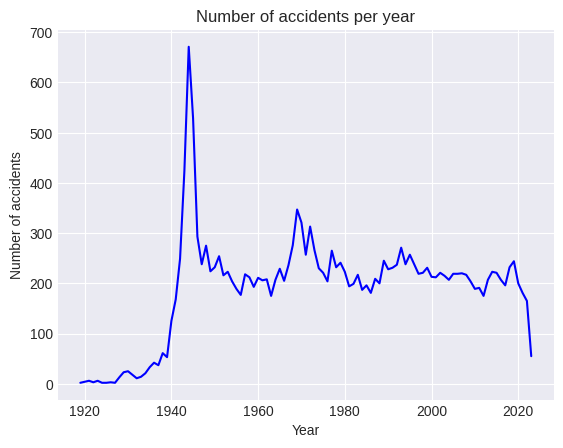

In [ ]:
occurred_per_year = occurred_per_year.sort_index()

plt.style.use('seaborn-v0_8-darkgrid')

plt.plot(occurred_per_year.index, occurred_per_year.values, linestyle='-', color='b')

plt.title('Number of accidents per year')
plt.xlabel('Year')
plt.ylabel('Number of accidents')

plt.show()

From these results, we could hypothesize about the influence of World War II on the data reported in this dataset.

### In which country have more airplane disasters occurred?

In [ ]:
# calculating the sum of accidents for every nations
occurred_per_nations = data['country'].value_counts()

occurred_per_nations.head(10)

country
USA          3966
Russia       1284
Canada        791
U.K.          719
Brazil        573
France        452
India         444
Colombia      434
Germany       417
Indonesia     383
Name: count, dtype: int64

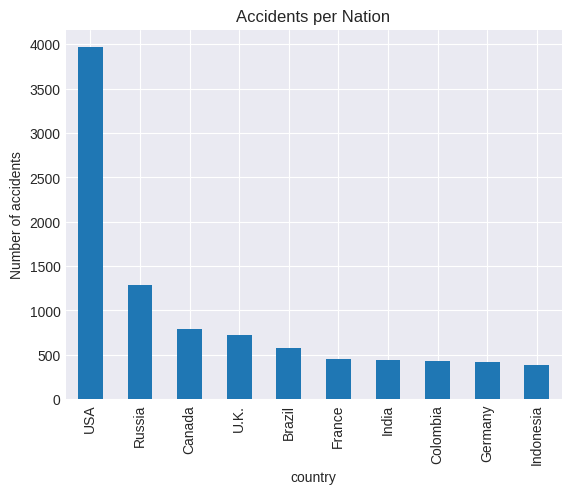

In [ ]:
occurred_per_nations.head(10).plot(kind='bar', title='Accidents per Nation')
plt.ylabel('Number of accidents')
plt.show()

The USA by far has the most airplane accidents. This could be influenced by the fact that airplanes are one of the most commonly used means of transportation between states in the USA.

### Do accidents occur more frequently on certain days of the week?

In [ ]:
# creating a new column to associate every accident to a week day
data['day_of_week'] = data['date'].dt.day_name()

# calculating the sum of accidents for every day of the week
occurred_per_weekday = data['day_of_week'].value_counts()

occurred_per_weekday.head(7)

day_of_week
Friday       3066
Wednesday    3006
Thursday     3002
Tuesday      2942
Monday       2806
Saturday     2656
Sunday       2322
Name: count, dtype: int64

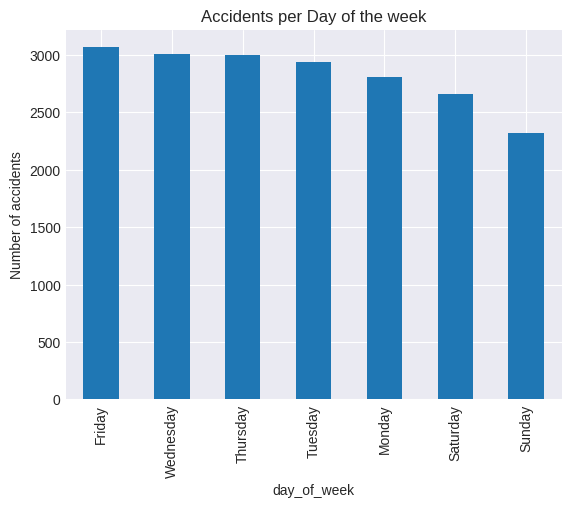

In [ ]:
occurred_per_weekday.plot(kind='bar', title='Accidents per Day of the week')
plt.ylabel('Number of accidents')
plt.show()

Sunday is the day least affected by airplane accidents. This data is likely linked to fewer people traveling on Sundays and, consequently, fewer routes being covered on this day.

### What is the safest operator?

In [ ]:
# calculating the number of deaths and accident for every operator
operator_stats = data.groupby('operator').agg(
    total_fatalities=('fatalities', 'sum'),
    num_accidents=('operator', 'count')
).reset_index()

# filtering in order to have only operator with 0 deaths in 6 or more accidents
filtered_operators = operator_stats.query('total_fatalities == 0 and num_accidents > 5')

top_operators = filtered_operators.sort_values(by=['total_fatalities', 'num_accidents'], ascending=[True, False])

print(top_operators)

                                   operator  total_fatalities  num_accidents
4353                                Ryanair               0.0             13
5197                Trans Maldivian Airways               0.0             12
1354                        Buffalo Airways               0.0             11
5369                             US Airways               0.0              9
5471                     Universal Airlines               0.0              9
857                            America West               0.0              7
869                 American Eagle Airlines               0.0              7
2623                            Horizon Air               0.0              7
3380                              Mahan Air               0.0              7
464   Air Canada Express, opb Jazz Aviation               0.0              6
1333               British Antarctic Survey               0.0              6
5302                             Tropic Air               0.0              6

The list above shows the "safest" operators, intended as the operators which have had the more than 5 accidents with 0 human losses.

### Which aircraft has caused the most deaths?

In [ ]:
# calculating the sum of accidentsdeaths for every type of vehicle
deaths_per_type = data.groupby('type')['fatalities'].sum()

deaths_per_type = deaths_per_type.sort_values(ascending=False)

deaths_per_type.head(10)

type
Douglas C-47A (DC-3)        5780.0
Douglas C-47 (DC-3)         2665.0
Douglas C-47B (DC-3)        2017.0
Boeing 767-223ER            1692.0
Tupolev Tu-154M             1600.0
DC-9-32                     1441.0
Ilyushin Il-18V             1356.0
Lockheed C-130H Hercules    1271.0
Antonov An-26               1245.0
Junkers Ju-52/3m            1110.0
Name: fatalities, dtype: float64

The top 3 types of airplanes are all variants of the same model, the Douglas C-47, a military model used during World War II, confirming the hypothesis made earlier.

### How are the incidents distributed by ASN category?

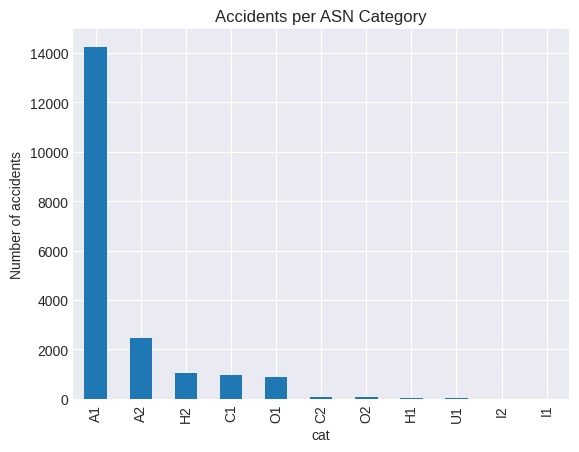

In [ ]:
# calculating the number of accidents for every category
occurred_per_cat = data['cat'].value_counts().sort_values(ascending=False)

occurred_per_cat.plot(kind='bar', title='Accidents per ASN Category')
plt.ylabel('Number of accidents')
plt.show()

As we can see most of accidents belong to the category A, which means the accident has been relevant. In particular, A1 means a total loss of the plane.

### How have accidents evolved since September 11th?

In [ ]:
# searching the first date in the dataset
first_date = data['date'].min()

# searching the last date in the dataset
last_date = data['date'].max()

x_date = pd.Timestamp('2001-09-11')

# calculating the number of days until 11/09/2001
days_before_9_11 = (x_date - first_date).days

# calculating the number of days from 11/09/2001
days_after_9_11 = (last_date - x_date).days

# filtering the data according to the date of occurrence
occurred_before_9_11 = data[data['date'] < x_date]
occurred_after_9_11 = data[data['date'] >= x_date]

# counting the accidents according to the date of occurrence
num_accs_before = len(occurred_before_9_11)
num_accs_after = len(occurred_after_9_11)

# calculating the ratio of accidents over days according to the date of occurrence
ratio_before = num_accs_before / days_before_9_11
ratio_after = num_accs_after / days_after_9_11

print(f"Ratio of accidents per days before September 11th: {ratio_before:.2f}")
print(f"Ratio of accidents per days after September 11th: {ratio_after:.2f}")

Ratio of accidents per days before September 11th: 0.51
Ratio of accidents per days after September 11th: 0.57


Unexpectedly, the daily incidence rate of accidents increased after September 11, 2001. Let's analyze the trend by year in the USA, highlighting periods before and after that date:

In [ ]:
# new columns to store information
data['post_9_11'] = data['date'] > x_date

# filtering to obtain only accidents in the USA
occurred_usa = data[data['country'] == 'USA']

# filtering the data according to the date of occurrence
before_11_09 = occurred_usa[occurred_usa['post_9_11'] == False]
after_11_09 = occurred_usa[occurred_usa['post_9_11'] == True]

# counting the data according to the year of occurrence
accs_per_year_before = before_11_09['year'].value_counts().sort_index()
accs_per_year_after = after_11_09['year'].value_counts().sort_index()

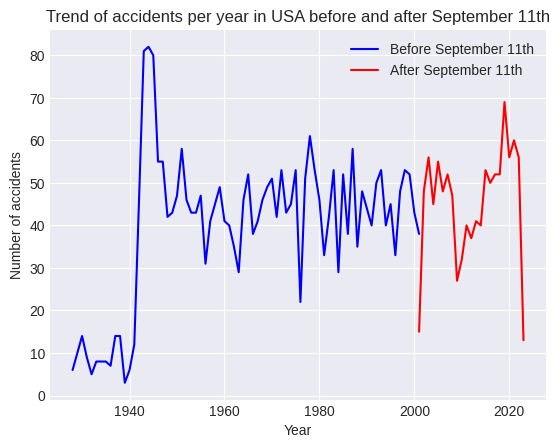

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')

plt.plot(accs_per_year_before.index, accs_per_year_before.values, linestyle='-', color='b', label='Before September 11th')

plt.plot(accs_per_year_after.index, accs_per_year_after.values, linestyle='-', color='r', label='After September 11th')

plt.title('Trend of accidents per year in USA before and after September 11th')
plt.xlabel('Year')
plt.ylabel('Number of accidents')
plt.legend()

plt.show()

The annual analysis also confirms what was said earlier.

## (Bonus) Cartogram

To create the cartogram, let's use only the top 10 countries by number of accidents, for practical reasons.

In [ ]:
# resetting index
occurred_per_nations = occurred_per_nations.reset_index()

# dividing the values ​​into two columns to associate them with the cartogram
occurred_per_nations.columns = ['country', 'accident_count']

# creating a dataframe of the  top 10 nations per number of accidents
top_10_nations = occurred_per_nations.head(10)
print(top_10_nations)

     country  accident_count
0        USA            3966
1     Russia            1284
2     Canada             791
3       U.K.             719
4     Brazil             573
5     France             452
6      India             444
7   Colombia             434
8    Germany             417
9  Indonesia             383


One of the practical reasons is that the names of the nations in the dataset need to match those on the map for proper visualization.

In [ ]:
# extracting names of country in the new dataframe
nations_dataset = top_10_nations['country'].unique()

# # extracting names of country in the geopandas world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
nations_geo = world['name'].unique()

# searching for names which don't match
not_found = [nation for nation in nations_dataset if nation not in nations_geo]

print("Nations no found:", not_found)

Nations no found: ['USA', 'U.K.']


<ipython-input-62-22a7d6e4b20c>:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [ ]:
country_mapping = {
    "USA": "United States of America",
    "U.K.": "United Kingdom"
}

# mapping country names on dataframe to match with world map
top_10_nations['country'] = top_10_nations['country'].replace(country_mapping)

print(top_10_nations)

                    country  accident_count
0  United States of America            3966
1                    Russia            1284
2                    Canada             791
3            United Kingdom             719
4                    Brazil             573
5                    France             452
6                     India             444
7                  Colombia             434
8                   Germany             417
9                 Indonesia             383


<ipython-input-63-749455848240>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_nations['country'] = top_10_nations['country'].replace(country_mapping)


In [ ]:
# joining data
world_accs = world.merge(top_10_nations, how='left', left_on='name', right_on='country')

world_accs = world_accs.dropna(subset=['accident_count'])

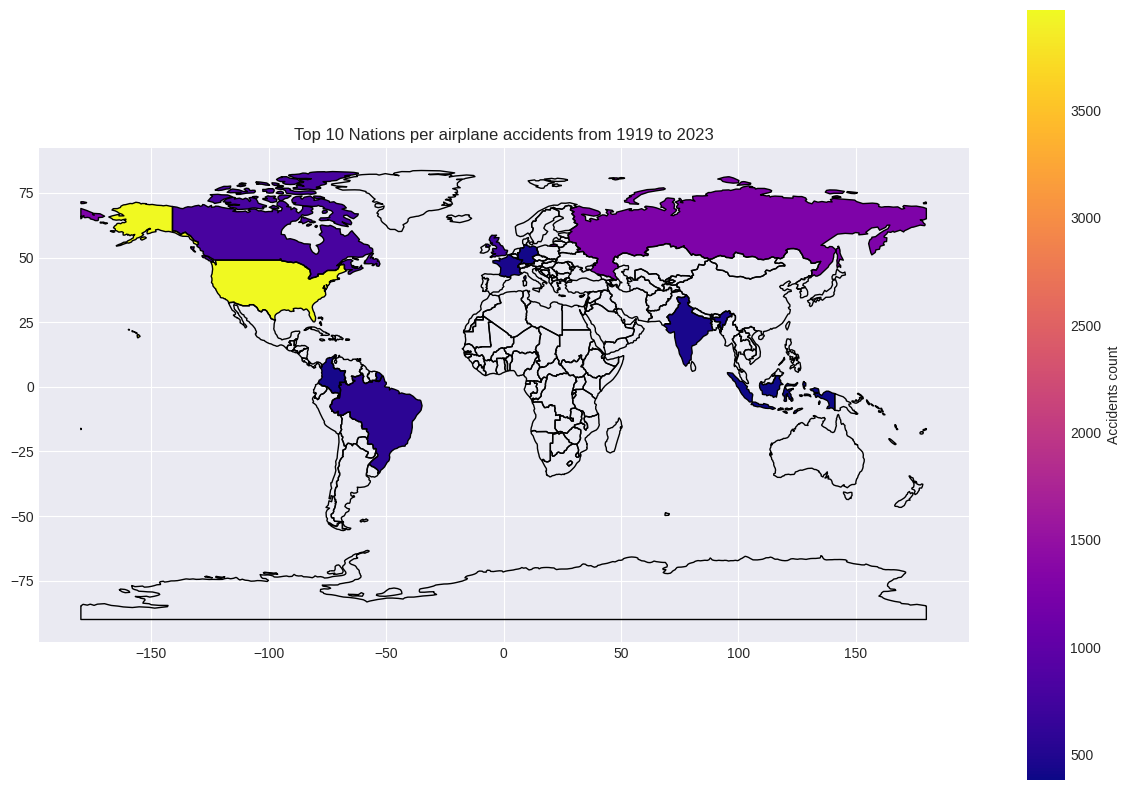

In [ ]:
#creating world map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world.boundary.plot(ax=ax, linewidth=1, color='black')

# defining graph parameters
world_accs.plot(column='accident_count', ax=ax, legend=True,
                     legend_kwds={'label': "Accidents count",
                                  'orientation': "vertical"},
                     cmap='plasma', missing_kwds={"color": "lightgrey"})

plt.title('Top 10 Nations per airplane accidents from 1919 to 2023')
plt.show()